In [1]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import importlib
import window_generator
# importlib.reload(window_generator)
from window_generator import WindowGenerator

2024-02-06 15:55:26.333778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 15:55:26.333830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 15:55:26.335362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 15:55:26.343517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
df = df[5::6] # get hourly data by subsampling every 6th 10-min record
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [4]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


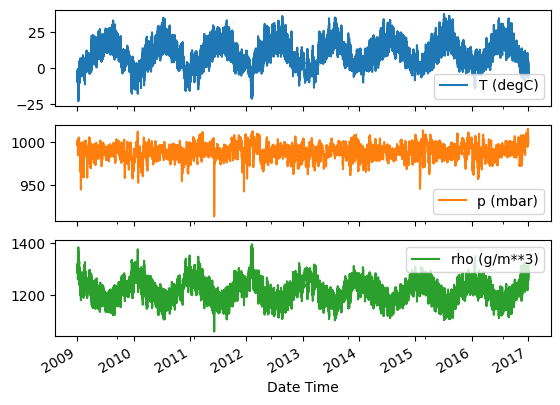

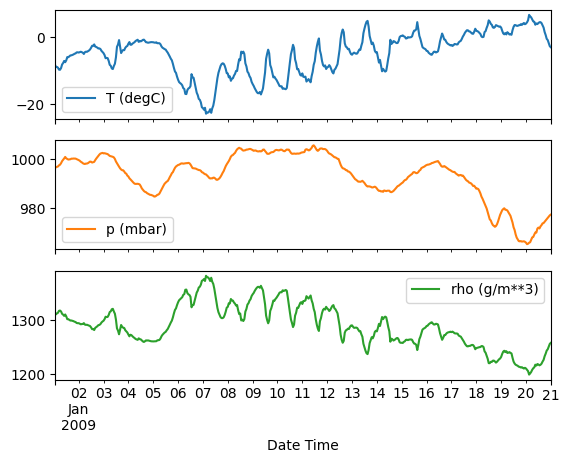

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

# Preprocessing

* Remove obviously incorrect values
* Feature engineering
    * use wind deg and sinf velocity to construct an x,y vector
    * decompose timestamp to day and year sin and cos (4 signals): we confirm day and year frequencies by applying the real-valued fft

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [8]:
# remove wind erroneus values
df[df['wv (m/s)']==-9999.00] = 0.0
df[df['max. wv (m/s)']==-9999.00] = 0.0

In [9]:
df[['wv (m/s)', 'max. wv (m/s)']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
wv (m/s),70091.0,2.130451,1.543044,0.0,0.99,1.76,2.86,14.01
max. wv (m/s),70091.0,3.533671,2.343417,0.0,1.76,2.98,4.74,23.50


Text(0, 0.5, 'Wind Velocity [m/s]')

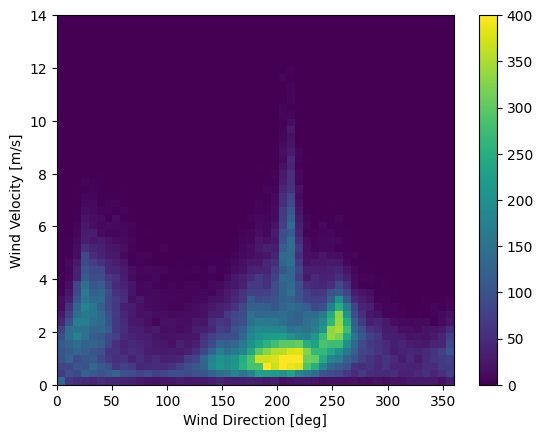

In [10]:
# wind direction & wind velocity
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [11]:
# convert the two fearures, wind direction and wind velocity to a --> wind vector
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd_deg = df.pop('wd (deg)')

# convert to radians
wd_rad = wd_deg*np.pi / 180 

# wind x and y components
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# max wind x and y components
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [12]:
df[['Wx', 'Wy', 'max Wx', 'max Wy']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wx,70091.0,-0.627842,1.987415,-11.305514,-1.470727,-0.633142,0.299898,8.244699
Wy,70091.0,-0.406985,1.552488,-8.274385,-1.364651,-0.293455,0.450077,7.733831
max Wx,70091.0,-1.018681,3.095279,-19.641473,-2.469210,-1.117029,0.627619,11.913133
max Wy,70091.0,-0.733589,2.611890,-14.883367,-2.322709,-0.527021,0.822895,14.302308


Text(0, 0.5, 'Wind Y [m/s]')

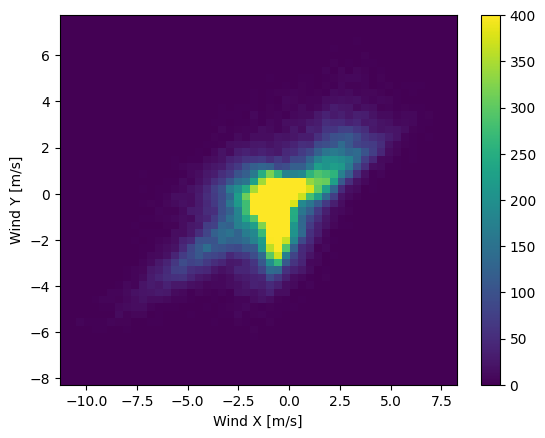

In [13]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')

In [14]:
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

In [15]:
# date_time to seconds 
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [16]:
# breakdown the timestamp_s into 2 signals x period (day, year)
# for every period: sin & cos
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

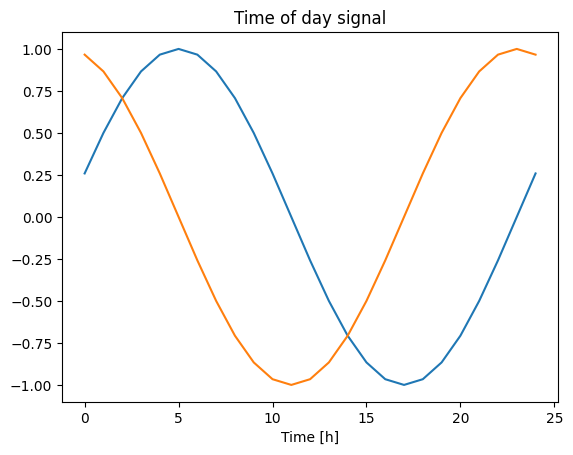

In [17]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

2024-02-06 15:55:35.768849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 15:55:35.778112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 15:55:35.780024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

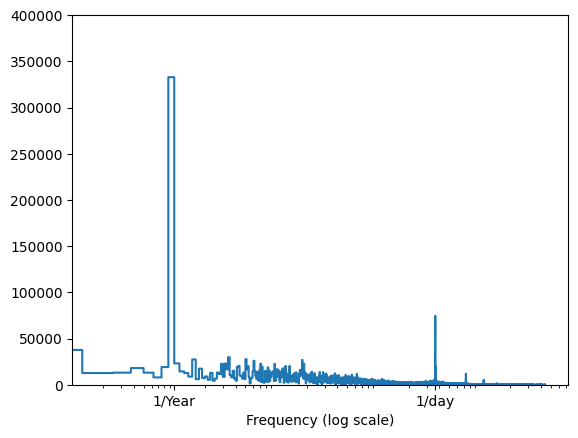

In [18]:
fft = tf.signal.rfft(df['T (degC)'])
n_samples_h = len(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)
f_per_year = f_per_dataset/years_per_dataset

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [19]:
# split data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [20]:
# normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

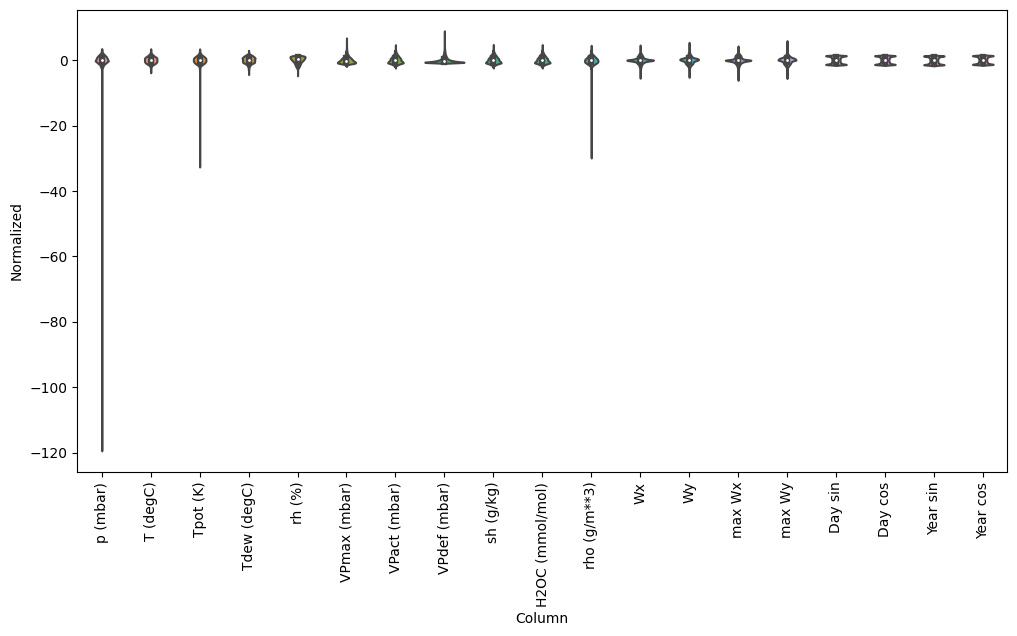

In [21]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [22]:
wg = WindowGenerator(input_width=10, 
                     label_width=1, 
                     shift=1,
                     label_columns=['T (degC)'],
                     train_df=train_df,
                     val_df=val_df,
                     test_df=test_df)
wg

Total window size: 11
Input size: 10
Label size: 1
Label shift: 1

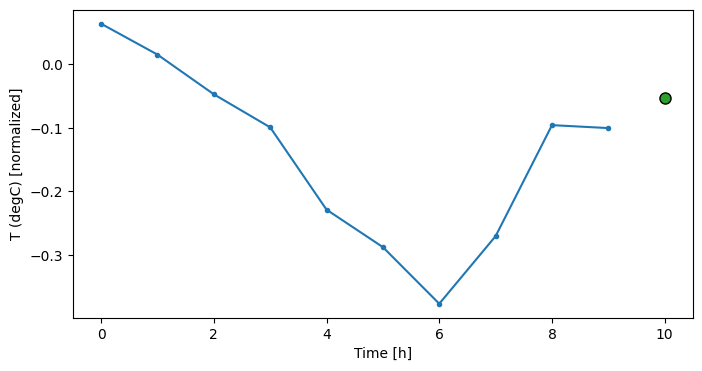

In [23]:
wg.plot()

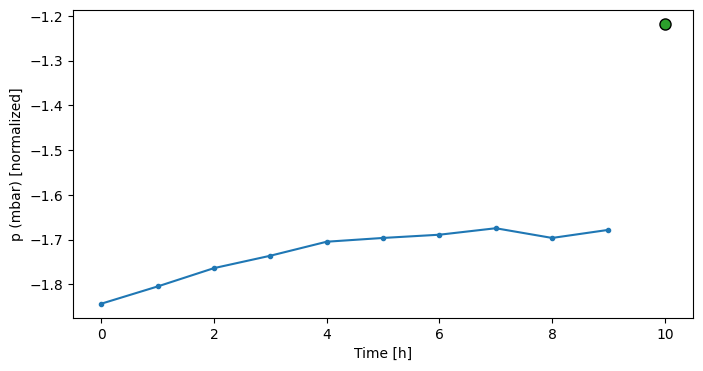

In [24]:
wg.plot(plot_col='p (mbar)')

In [25]:
wg.train.element_spec

(TensorSpec(shape=(None, 10, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

# Single step models

In [26]:
import window_generator
importlib.reload(window_generator)
from window_generator import WindowGenerator
single_step_wg = WindowGenerator(input_width=24, 
                     label_width=1, 
                     shift=1,
                     label_columns=['T (degC)'],
                     train_df=train_df,
                     val_df=val_df,
                     test_df=test_df)
single_step_wg

Total window size: 25
Input size: 24
Label size: 1
Label shift: 1

In [28]:
example_features, example_label = next(iter(single_step_wg.train.take(1)))
print('Input shape:', example_features.shape)
print('Output shape:', example_label.shape)

Input shape: (32, 24, 19)
Output shape: (32, 1, 1)


## Naieve (predict t-1)

In [29]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, -1, tf.newaxis]

In [30]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_wg.val)
performance['Baseline'] = baseline.evaluate(single_step_wg.test, verbose=0)

438/438 [==============================] - 2s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.0787


In [31]:
val_performance, performance

({'Baseline': [0.013437840156257153, 0.078706294298172]},
 {'Baseline': [0.01420813798904419, 0.08539815992116928]})

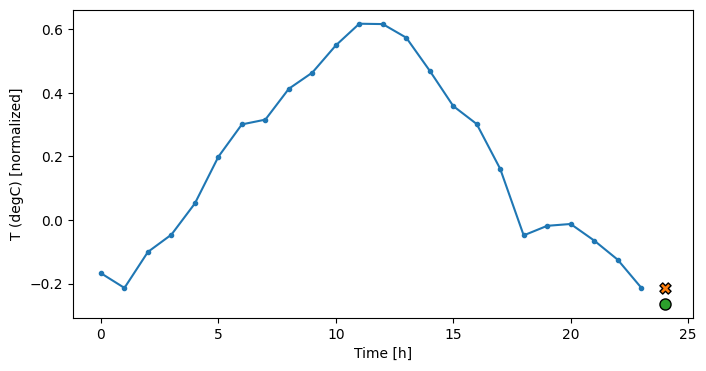

In [32]:
single_step_wg.plot(baseline)

## Linear Model

In [33]:
linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Dense(units=1)) # without any activation func set its Linear (default)
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [34]:
history = compile_and_fit(linear_model, single_step_wg)

val_performance['Linear'] = linear_model.evaluate(single_step_wg.val)
performance['Linear'] = linear_model.evaluate(single_step_wg.test, verbose=0)

Epoch 1/20


2024-02-06 15:56:33.147649: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f72b80014c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-06 15:56:33.147688: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-02-06 15:56:33.155088: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-06 15:56:33.179651: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1707234993.267039 3200760 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1533/1533 [==============================] - 6s 4ms/step - loss: 0.2923 - mean_absolute_error: 0.4029 - val_loss: 0.3096 - val_mean_absolute_error: 0.3299
Epoch 2/20
1533/1533 [==============================] - 6s 4ms/step - loss: 0.1853 - mean_absolute_error: 0.3382 - val_loss: 0.2891 - val_mean_absolute_error: 0.3270
Epoch 3/20
1533/1533 [==============================] - 5s 4ms/step - loss: 0.1834 - mean_absolute_error: 0.3363 - val_loss: 0.2818 - val_mean_absolute_error: 0.3260
Epoch 4/20
1533/1533 [==============================] - 5s 4ms/step - loss: 0.1826 - mean_absolute_error: 0.3355 - val_loss: 0.2766 - val_mean_absolute_error: 0.3254
Epoch 5/20
1533/1533 [==============================] - 5s 3ms/step - loss: 0.1823 - mean_absolute_error: 0.3351 - val_loss: 0.2712 - val_mean_absolute_error: 0.3244
Epoch 6/20
1533/1533 [==============================] - 6s 4ms/step - loss: 0.1822 - mean_absolute_error: 0.3350 - val_loss: 0.2670 - val_mean_absolute_error: 0.3240
Epoch 7/20
1533

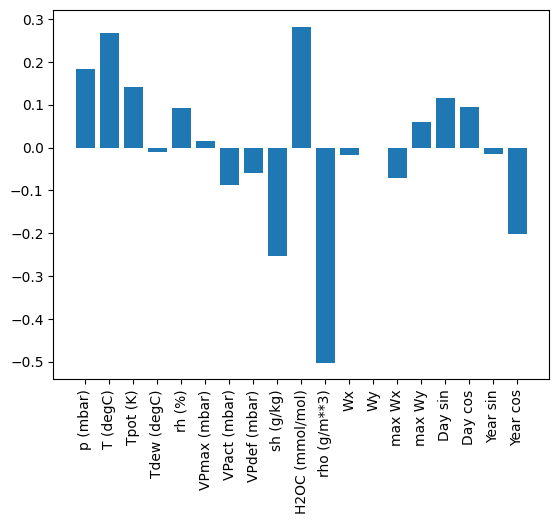

In [35]:
# weights, interpretability
plt.bar(x = range(len(train_df.columns)),
        height=linear_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense (FCNN)

In [36]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_wg)

val_performance['Dense'] = dense.evaluate(single_step_wg.val)
performance['Dense'] = dense.evaluate(single_step_wg.test, verbose=0)

Epoch 1/20
1533/1533 [==============================] - 10s 6ms/step - loss: 0.1782 - mean_absolute_error: 0.3291 - val_loss: 0.2021 - val_mean_absolute_error: 0.3188
Epoch 2/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.1689 - mean_absolute_error: 0.3213 - val_loss: 0.1867 - val_mean_absolute_error: 0.3120
Epoch 3/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.1674 - mean_absolute_error: 0.3199 - val_loss: 0.1734 - val_mean_absolute_error: 0.3108
Epoch 4/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.1665 - mean_absolute_error: 0.3188 - val_loss: 0.1682 - val_mean_absolute_error: 0.3117
Epoch 5/20
1533/1533 [==============================] - 9s 6ms/step - loss: 0.1654 - mean_absolute_error: 0.3177 - val_loss: 0.1734 - val_mean_absolute_error: 0.3173
Epoch 6/20
438/438 [==============================] - 2s 4ms/step - loss: 0.1694 - mean_absolute_error: 0.3190


## LSTM

In [37]:
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.LSTM(24, return_sequences=True))
lstm.add(tf.keras.layers.LSTM(64, return_sequences=True))
lstm.add(tf.keras.layers.LSTM(64))
lstm.add(tf.keras.layers.Dense(1))

history_lstm = compile_and_fit(lstm, single_step_wg)

val_performance['LSTM'] = lstm.evaluate(single_step_wg.val)
performance['LSTM'] = lstm.evaluate(single_step_wg.test, verbose=0)

Epoch 1/20
1533/1533 [==============================] - 19s 10ms/step - loss: 0.0293 - mean_absolute_error: 0.1157 - val_loss: 0.0083 - val_mean_absolute_error: 0.0651
Epoch 2/20
1533/1533 [==============================] - 13s 9ms/step - loss: 0.0073 - mean_absolute_error: 0.0617 - val_loss: 0.0068 - val_mean_absolute_error: 0.0567
Epoch 3/20
1533/1533 [==============================] - 14s 9ms/step - loss: 0.0070 - mean_absolute_error: 0.0595 - val_loss: 0.0067 - val_mean_absolute_error: 0.0564
Epoch 4/20
1533/1533 [==============================] - 14s 9ms/step - loss: 0.0067 - mean_absolute_error: 0.0578 - val_loss: 0.0071 - val_mean_absolute_error: 0.0575
Epoch 5/20
438/438 [==============================] - 2s 4ms/step - loss: 0.0074 - mean_absolute_error: 0.0595


In [38]:
def plot_perf_metrics(results_dict, metrics=['mse', 'mae'], label=None):
    width = 0.2  # the width of the bars
    model_names = list(performance.keys())
    x = np.arange(len(model_names))  # the label locations
    fig, ax = plt.subplots(layout='constrained')

    for i, metric in enumerate(metrics):
        offset = width * i
        values = [results_dict[model][i] for model in model_names]
        ax.bar(x+ offset, values, width, label=metric)
        
    ax.set_ylabel('Error')
    ax.set_title(label if label else 'Models Perfromance')
    ax.set_xticks(x + width, model_names)
    ax.legend(loc='upper left', ncols=2)
 
    plt.show()

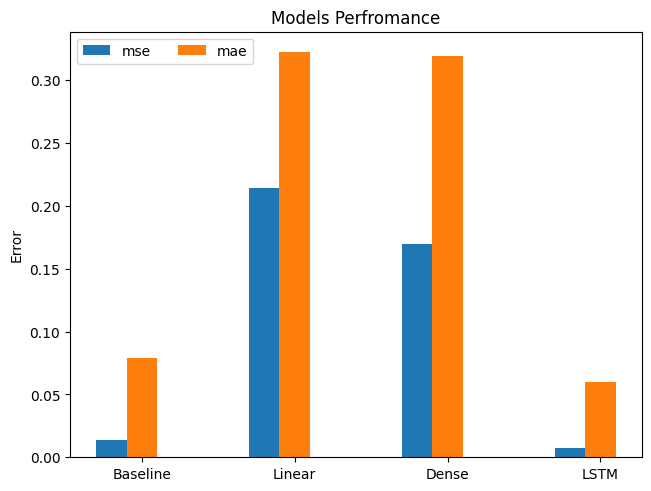

In [39]:
plot_perf_metrics(val_performance)

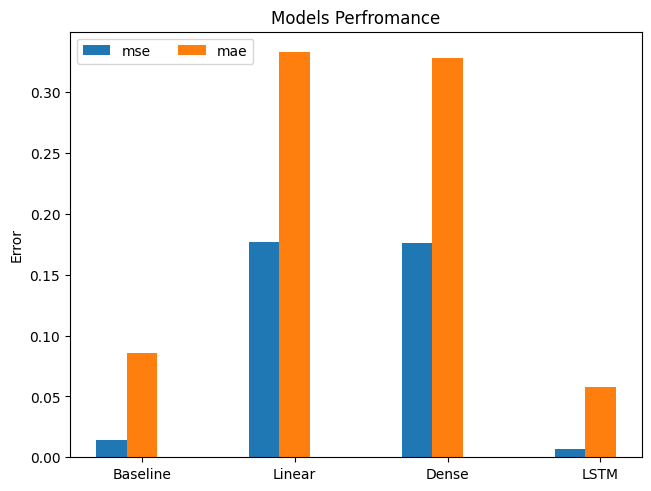

In [40]:
plot_perf_metrics(performance)